### EE6310: Image and Video Processing
### Assignment 3

In [119]:
import numpy as np
import matplotlib.pyplot as plt

In [120]:
def read_image(path):
    image = plt.imread(path)
    return image

def display_image(image, size = 4, title = None):
    aspect_ratio = image.shape[1]/image.shape[0]
    plt.figure(figsize=(size*aspect_ratio, size))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.show()

In [121]:
def DFT(image, centering = False):
    N = image.shape[0]
    matrix = np.zeros((N, N), dtype = np.complex128)

    w_n = np.exp(-2j * np.pi/N)

    for i in range(N):
        for j in range(N):
            if (centering):
                matrix[i][j] = (w_n ** (i * j)) * (-1) ** (i + j)
            else:
                matrix[i][j] = (w_n ** (i * j))

    I_DFT = np.dot((np.dot(matrix, image)), matrix)

    return I_DFT

In [122]:
def IDFT(dft):
    N = dft.shape[0]
    matrix = np.zeros((N, N), dtype = np.complex128)
    IDFT = np.zeros((N, N), dtype = np.float32)

    w_n = np.exp(-2j * np.pi/N)

    for i in range(N):
        for j in range(N):
            matrix[i][j] =(1/N) * w_n ** (-1*(i * j))

    IDFT = np.dot((np.dot(matrix, dft)), matrix)

    return IDFT

In [123]:
def pointwise_adding_scaling(image, P, L):

    new_image = np.zeros(image.shape, dtype = np.uint32)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            new_image[i][j] = np.round(P * image[i][j] + L)

            if (new_image[i][j] < 0):
                new_image[i][j] = 0
            elif (new_image[i][j] > 255):
                new_image[i][j] = 255
    return new_image

In [124]:
def log_magnitude_compression(image):
    new_image = np.zeros((image.shape[0], image.shape[1]), dtype = 'uint8')

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            new_image[i][j] = np.log(image[i][j] + 1)
    return new_image

In [125]:
def FSCS(image):
    A = np.amin(image)
    B = np.amax(image)
    K = 256

    P = (K - 1)/(B - A)
    L = -1 * A * (K - 1)/(B - A)

    new_image = pointwise_adding_scaling(image, P, L)
    
    return new_image

#### 1. Periodic Convolution
1. Write a program to circularly convolve two images. Test your program by using an image and an averaging filter of
size 5 × 5. Verify that the IDFT of the product of the image and filter DFT does indeed result in circular convolution.

In [126]:
def circularConv(image1, image2):
    convolved_image = np.zeros(image1.shape)
    N = image1.shape[0]
    M = image1.shape[1]

    P = image2.shape[0]
    Q = image2.shape[1]

    for i in range(N):
        for j in range(M):
            for p in range(P):
                for q in range(Q):
                    convolved_image[i, j] += image1[(i - p) % N, (j - q) % M] * image2[p, q]
    
    return convolved_image
    

In [127]:
def circularConv_withDFT(image1, image2):
    N = max(image1.shape[0], image2.shape[0])
    M = max(image1.shape[1], image2.shape[1])

    image1 = np.pad(image1, [(0, N - image1.shape[0]), (0, M - image1.shape[1])], mode = 'constant')
    image2 = np.pad(image2, [(0, N - image2.shape[0]), (0, M - image2.shape[1])], mode = 'constant')
    
    return np.round(np.real(IDFT(DFT(image1) * DFT(image2))))

IDFT of the product of the image and filter DFT results in circular convolution.


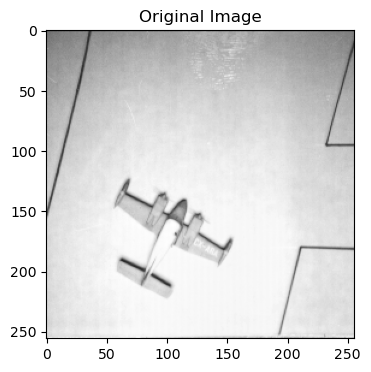

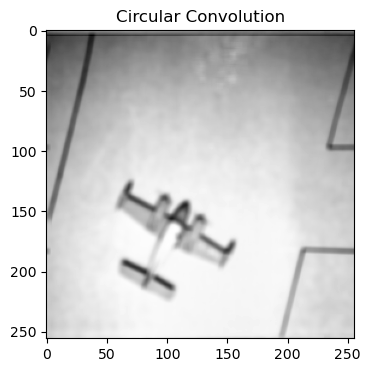

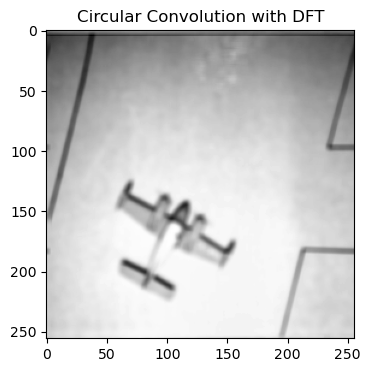

In [128]:
filter_size = 5
averaging_filter = np.ones((filter_size, filter_size)) / (filter_size * filter_size)

image1 = read_image('misc/5.1.11.tiff')

circularConv_output = circularConv(image1, averaging_filter)

if (np.array_equal(np.round(circularConv_output), circularConv_withDFT(image1, averaging_filter))):
    print("IDFT of the product of the image and filter DFT results in circular convolution.")
else:
    print("IDFT of the product of the image and filter DFT does not result in circular convolution.")

display_image(image1, title = "Original Image")
display_image(circularConv_output, title = "Circular Convolution")
display_image(circularConv_withDFT(image1, averaging_filter), title = "Circular Convolution with DFT")

2. Linearly convolve the same image and filter using the circular convolution function above after appropriate zero
padding.

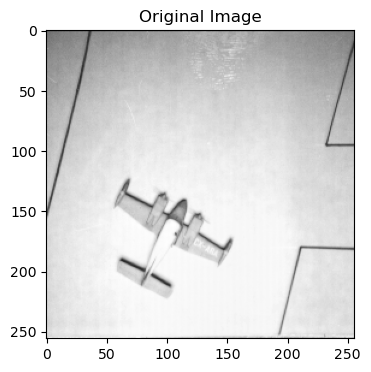

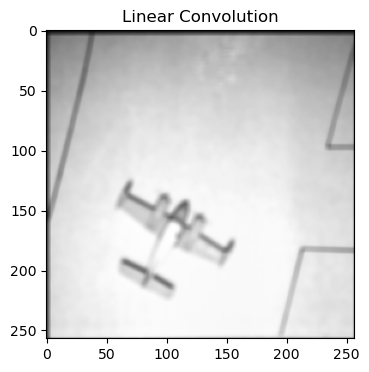

In [129]:
padded_filter = np.pad(averaging_filter, [(0, image1.shape[0] - 1), (0, image1.shape[1] - 1)], mode = 'constant')
padded_image = np.pad(image1, [(0, averaging_filter.shape[0] - 1), (0, averaging_filter.shape[1] - 1)], mode = 'constant')

linearConv_output = circularConv_withDFT(padded_image, padded_filter)[0:image1.shape[0] + 1, 0:image1.shape[1] + 1]
circular = circularConv_withDFT(image1, averaging_filter)
display_image(image1, title="Original Image")
display_image(linearConv_output, title = "Linear Convolution")

3. Experiment with different filter kernel sizes and present your observation on when direct linear convolution is faster
than the IDFT-DFT approach using zero padding.

In [130]:
def linearConv(image1, image2):
    convolved_image = np.zeros((image1.shape[0] + image2.shape[0] - 1, image1.shape[1] + image2.shape[1] - 1))
    N = image1.shape[0]
    M = image1.shape[1]

    P = image2.shape[0]
    Q = image2.shape[1]

    for i in range(N):
        for j in range(M):
            for p in range(P):
                for q in range(Q):
                    convolved_image[i, j] += image1[(i - p), (j - q)] * image2[p, q]
    
    return convolved_image

In [131]:
def linearConv_withDFT(image1, image2):

    image1 = np.pad(image1, [(0, image2.shape[0] - 1), (0, image2.shape[1] - 1)], mode = 'constant')
    image2 = np.pad(image2, [(0, image1.shape[0] - 1), (0, image1.shape[0] - 1)], mode = 'constant')
    
    return circularConv_withDFT(image1, image2) [0:image1.shape[0] + image2.shape[0] - 1, 0:image1.shape[1]+ image2.shape[1] - 1]

In [132]:
import time

filter_sizes = [1, 2, 5, 7, 10]

for filter_size in filter_sizes:
    averaging_filter = np.ones((filter_size, filter_size)) / (filter_size * filter_size)

    # Linear Convolution in spatial domain:
    start_time = time.time()
    linearConv_output = linearConv(image1, averaging_filter)
    end_time = time.time()

    # Linear Convolution in frequency domain:
    start_time_dft = time.time()
    linearConv_output_dft = linearConv_withDFT(image1, averaging_filter)
    end_time_dft = time.time()

    print("Filter Size:", filter_size)
    print("Time taken for Linear Convolution in spatial domain:", end_time - start_time)
    print("Time taken for Linear Convolution in frequency domain:", end_time_dft - start_time_dft)

Filter Size: 1
Time taken for Linear Convolution in spatial domain: 0.20380568504333496
Time taken for Linear Convolution in frequency domain: 0.2704136371612549
Filter Size: 2
Time taken for Linear Convolution in spatial domain: 0.4571866989135742
Time taken for Linear Convolution in frequency domain: 0.2836570739746094
Filter Size: 5
Time taken for Linear Convolution in spatial domain: 2.3970658779144287
Time taken for Linear Convolution in frequency domain: 0.2786984443664551
Filter Size: 7
Time taken for Linear Convolution in spatial domain: 4.506421089172363
Time taken for Linear Convolution in frequency domain: 0.3009765148162842
Filter Size: 10
Time taken for Linear Convolution in spatial domain: 8.57523775100708
Time taken for Linear Convolution in frequency domain: 0.3319528102874756


Only for filter size 1, Linear convolution in spatial domain is faster than frequency domain. In all other cases, linear convolution in frequency domain is faster.

We can see that the time taken by direct linear convolution is faster only for the case when filter size is 1.

#### 2. Linear Image Filters

We discussed various linear image filters in class. In this problem you will experiment with the various design parameters
to develop intuition on how to select them.

1. What is the filter parameter of the averaging filter? Experiment with different parameters and plot the DFT magnitude
spectrum at each parameter setting. Verify that this is indeed a low pass filter. What can you infer from the filter
spectrum in relation to the parameter values?

The filter parameter is the size of the averaging filter.

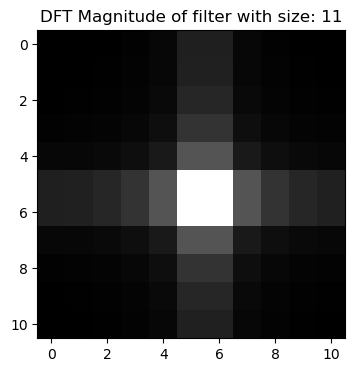

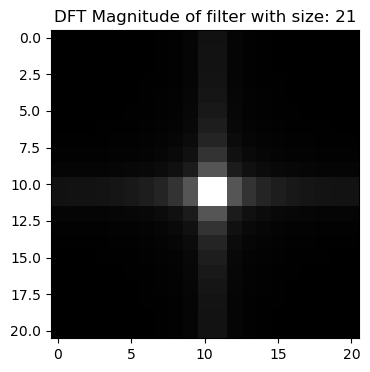

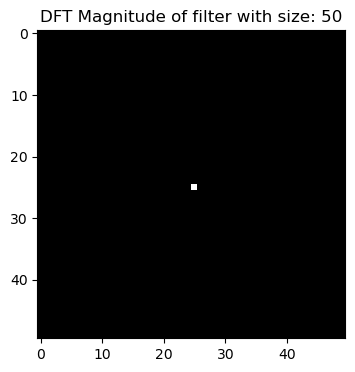

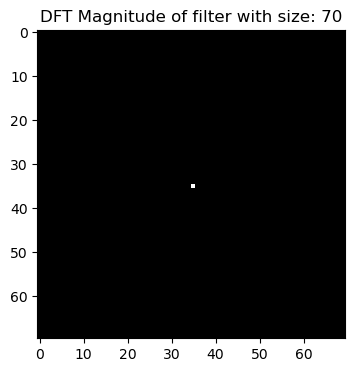

In [133]:
filter_sizes = [11, 21, 50, 70]
for filter_size in filter_sizes:
    averaging_filter = np.ones((filter_size, filter_size)) / (filter_size * filter_size)

    DFT_filter = DFT(averaging_filter, centering = True)

    DFT_mag = np.abs(DFT_filter)
    display_image(DFT_mag, title = f"DFT Magnitude of filter with size: {filter_size}")

**Concluding that the filter is low-pass**:
From the centered magnitude spectrum we can tell that the filter only passes the low-frequency components. Thus, it is a low pass filter.

**Relation of parameter values with filter spectrum**:
When the size of the filter increases as there is only a small portion of frequencies in the filter DFT is passed and the image will be smoothed out more. (as it only passes low frequency)

2. What are the filter parameters of the Gaussian filter? Experiment with different parameters and plot the DFT magnitude spectrum at each parameter setting. Verify that this is indeed a low pass filter. What can you infer from the filter spectrum in relation to the parameter values?

In [134]:
def gaussianFilter(sigma, N, M, centering = False):

    gaussian_filter = np.zeros((N, M))
    for u in range(N):
        for v in range(M):
            if centering:
                gaussian_filter[u][v] = np.exp(-2 * (np.pi**2) * (sigma**2) * (((u-N/2)**2 + (v-M/2)**2) / N ** 2))
            else:
                gaussian_filter[u][v] = np.exp(-2 * (np.pi**2) * (sigma**2) * (((u)**2 + (v)**2) / N ** 2))
    return gaussian_filter

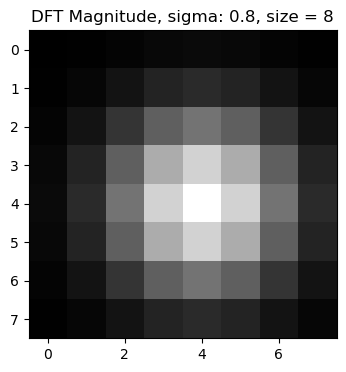

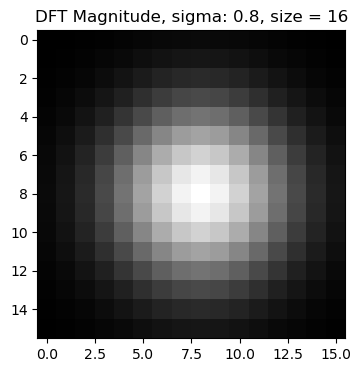

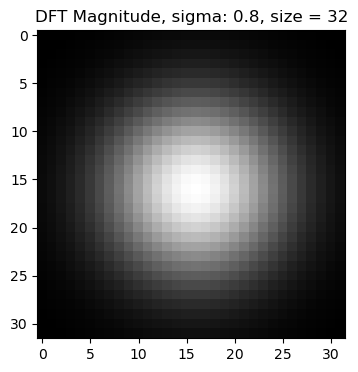

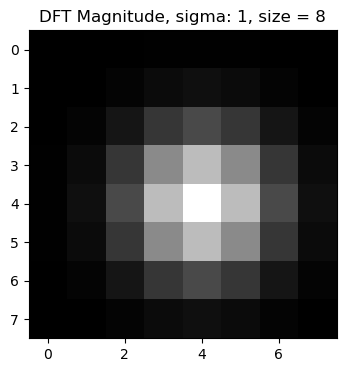

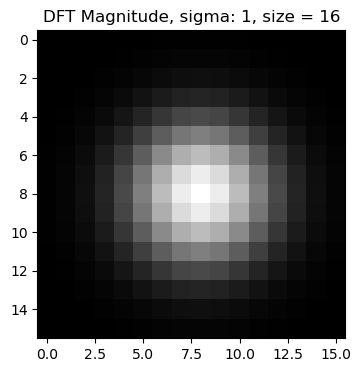

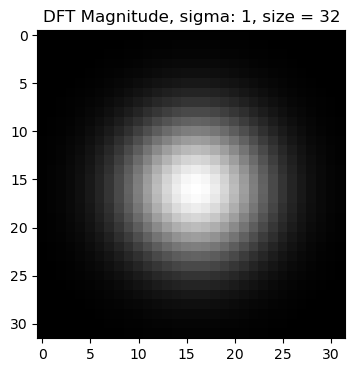

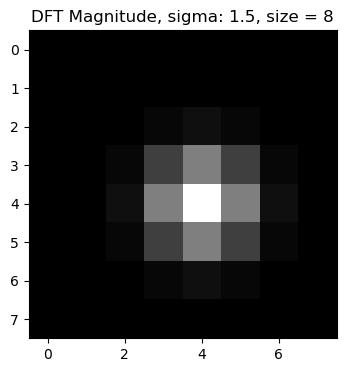

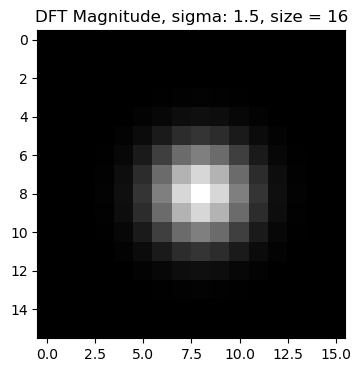

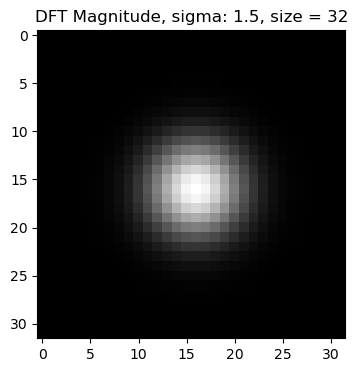

In [149]:
sigma_values = [0.8, 1, 1.5]
filter_sizes = [8, 16, 32]
for sigma in sigma_values:
    for filter_size in filter_sizes:
        gaussian_filter = gaussianFilter(sigma, filter_size, filter_size, centering = True)
        DFT_mag = np.abs(gaussian_filter)
        display_image(DFT_mag, title = f"DFT Magnitude, sigma: {sigma}, size = {filter_size}")

Filter parameters: $\sigma$, N, M

The filter allows only frequencies near the center in the centered frequency to pass. Thus, it is a low pass filter. <br/>
As $\sigma$ increases, the frequencies passed through the filter reduces (the standard deviation decreases). As N, M increases, the width of the kernel increases and the resolution of the filter increases.

3. Generate a band pass filter by taking the difference of two Gaussian filters. Verify from the DFT magnitude spectrum
that this is indeed a band pass filter. What are the parameters of this filter? Experiment with various parameters
values of the individual Gaussians. What can you infer from the filter spectrum in relation to the parameter values?

In [136]:
def gaussianFilter_freq(sigma, N, M):
    gaussian_filter = np.zeros((N, M))
    for u in range(N):
        for v in range(M):
            gaussian_filter[u][v] = np.exp(-2 * (np.pi**2) * (sigma**2) * (((u-N/2)**2 + (v-N/2)**2) / N ** 2))
    return gaussian_filter

In [137]:
def DoG(sigma1, sigma2, N, M, centering = False):
        gaussian_filter1 = gaussianFilter(sigma1, N, M, centering)
        gaussian_filter2 = gaussianFilter(sigma2, N, M, centering)
        DoG_filter = gaussian_filter1 - gaussian_filter2

        return DoG_filter

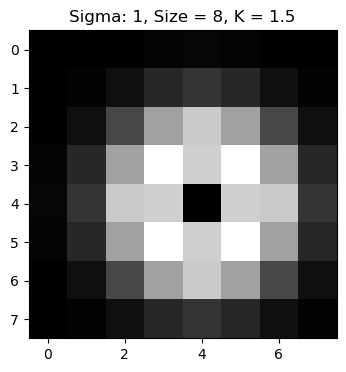

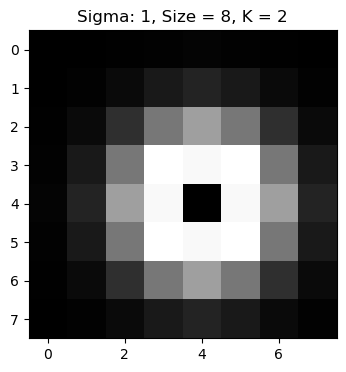

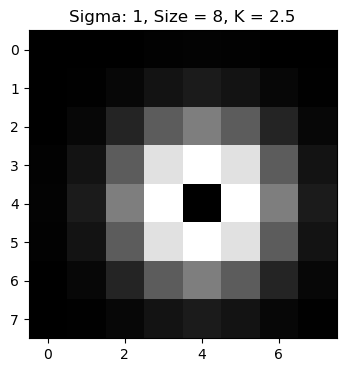

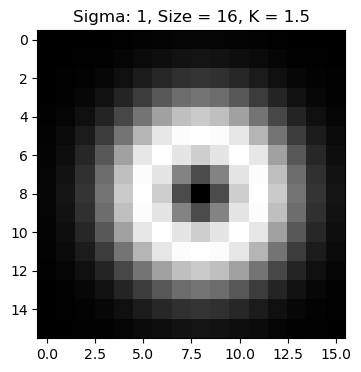

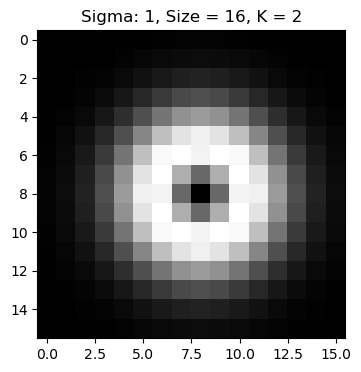

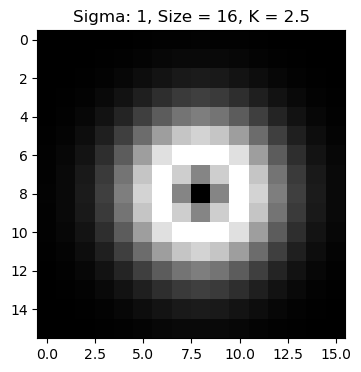

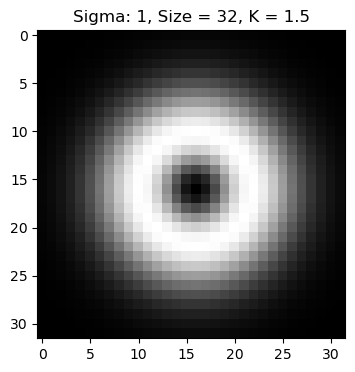

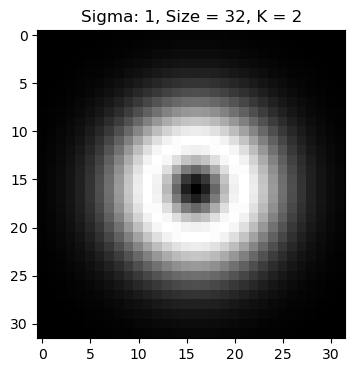

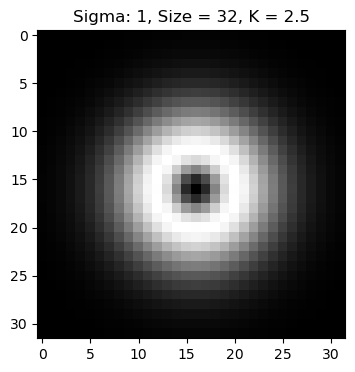

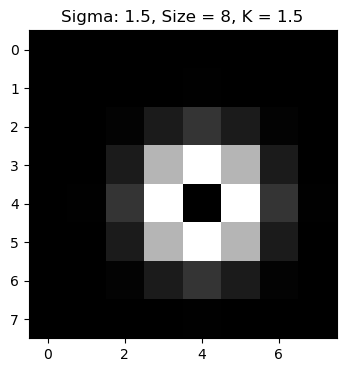

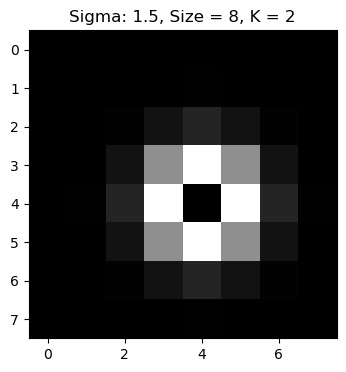

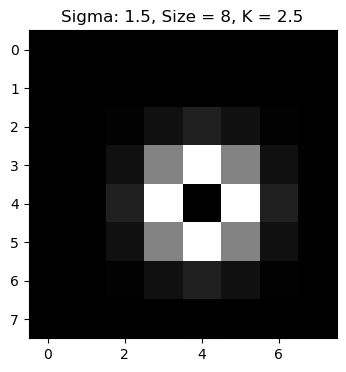

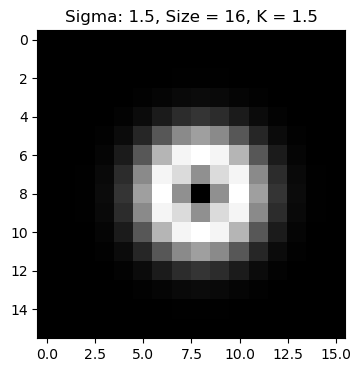

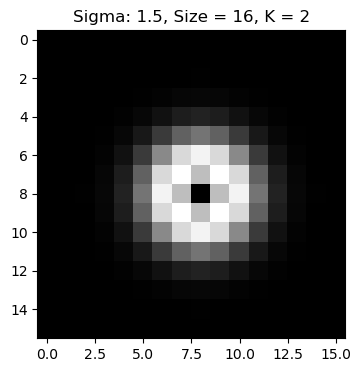

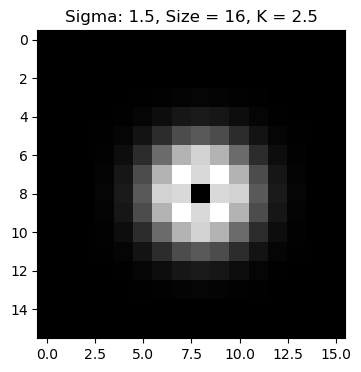

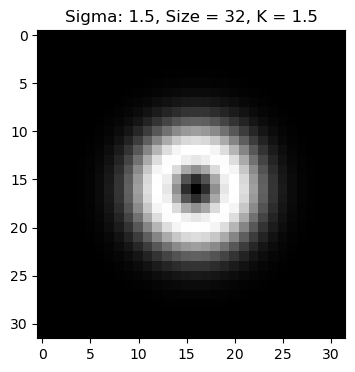

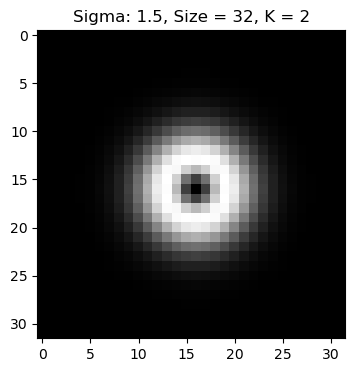

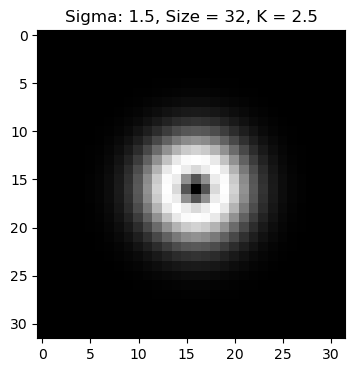

In [150]:
sigma_values = [1, 1.5]
filter_sizes = [8, 16, 32]
K = [1.5, 2, 2.5]
for sigma in sigma_values:
    for filter_size in filter_sizes:
        for k in K:
            bandPassFilter = DoG(sigma, k * sigma, filter_size, filter_size, centering = True)
            DFT_mag = np.abs(bandPassFilter)

            display_image(DFT_mag, title = f"Sigma: {sigma}, Size = {filter_size}, K = {k}")

The parameters of this filter are $\sigma$, size and K (i.e. the difference between the two $\sigma$ values). Clearly, in the centered DFT the low frequencies(middle part) are not passed and same for the high frequencies (edge). The middle frequencies are passed by the filter. Thus, its a band pass filter.

When K increases, the maximum frequency passed decreases. Similarly, when the $\sigma$ increases, the allowed bandpass decreases. When the size increases, the kernel size increases and the resolution of the kernel increases.

4. Plot the DFT magnitude spectrum of a Laplacian filter. Verify that this is a high pass filter.

In [139]:
def laplacian(A, N, M, centering = False):
    laplaceFilter = np.zeros((N, M), dtype = np.complex128)

    for u in range(N):
        for v in range(M):
            if centering:
                laplaceFilter[u, v] = A * ((u - N/2)**2/(N ** 2) + (v - M/2)**2/(M ** 2))
            else:
                laplaceFilter[u, v] = A * ((u)**2/(N ** 2) + (v)**2/(M ** 2))
    return laplaceFilter

With filter size: 8


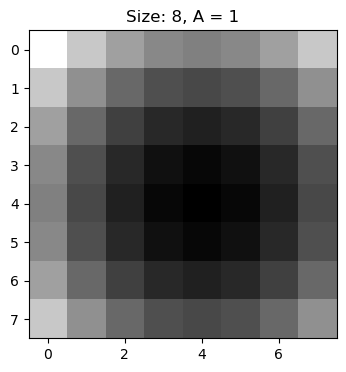

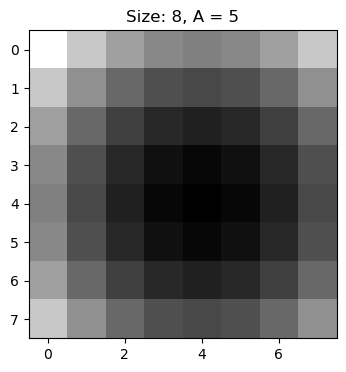

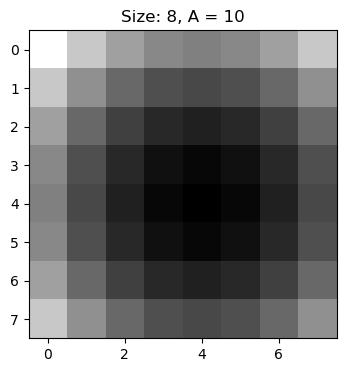

With filter size: 16


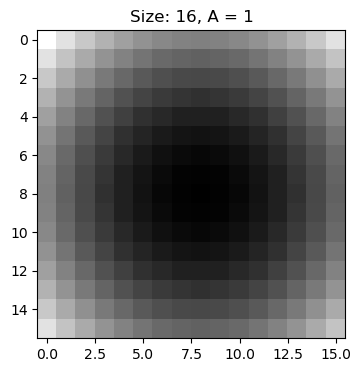

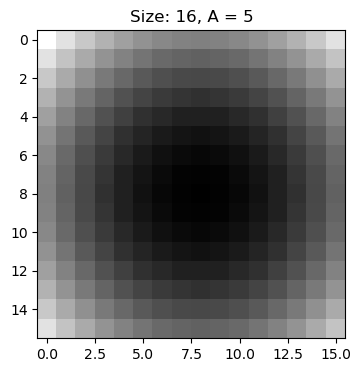

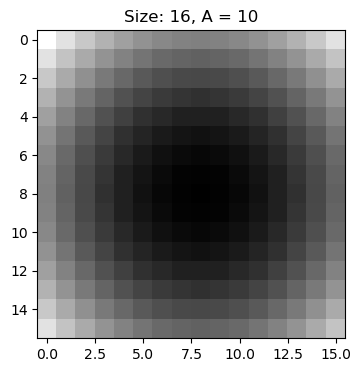

With filter size: 32


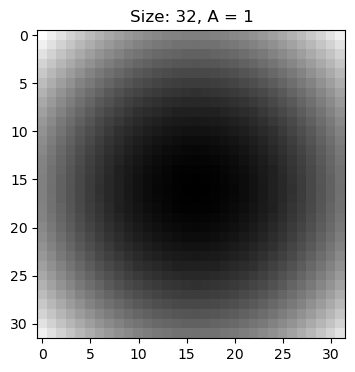

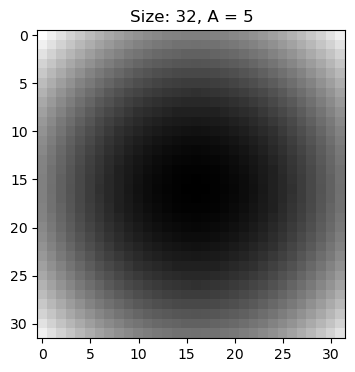

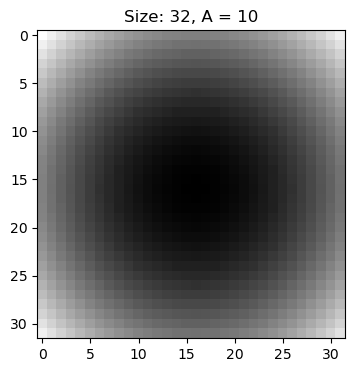

In [151]:
filter_sizes = [8, 16, 32]
A = [1, 5, 10]

for filter_size in filter_sizes:
    print("With filter size:", filter_size)
    for a in A:
        laplaceFilter = laplacian(a, filter_size, filter_size, centering=True)
        DFT_mag = np.abs(laplaceFilter)

        display_image(DFT_mag, title = f"Size: {filter_size}, A = {a}")

This filter passes the high frequencies, thus its a high pass filter.


#### 3. Applications of Linear Filters

1. In this problem you will denoise images using the linear filtering techniques discussed in class. Like the last assignment, use additive white Gaussian noise (AWGN) with zero mean and variance $σ^2$ = 25.

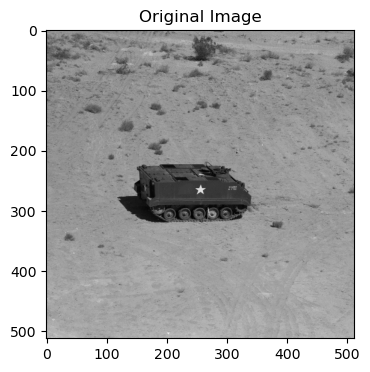

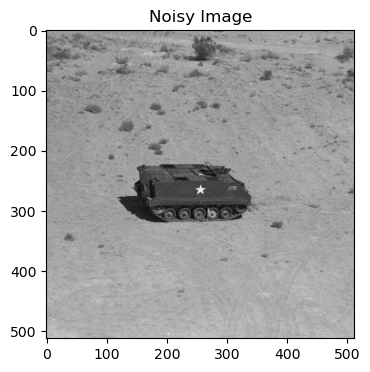

In [141]:
image1 = read_image('misc/7.1.08.tiff')
# adding gaussian noise:
np.random.seed(42)
noise = np.random.normal((0), (5), image1.shape)

noisy_image = image1 + noise

display_image(image1, title = "Original Image")
display_image(noisy_image, title = "Noisy Image")

Write a program to denoise the image using the following techniques:<br/>

(a) Average filter of size M × M. Vary M from 3 to 15 in increments of 2 and observe the tradeoff between denoising
and smoothing. What is an optimal window size for this noise level?

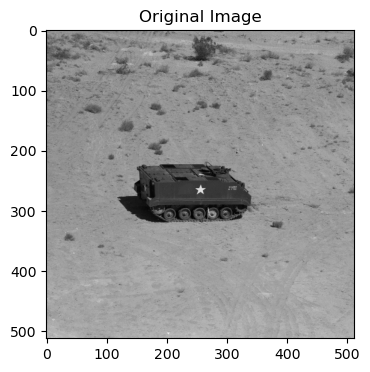

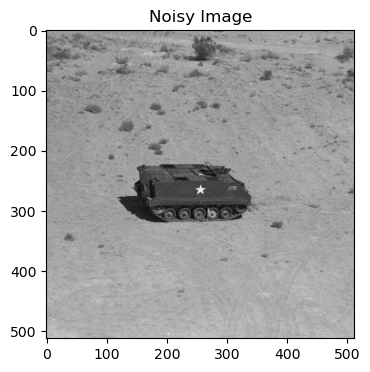

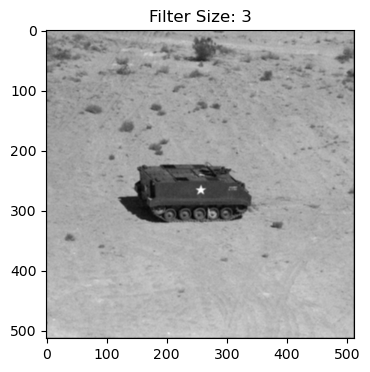

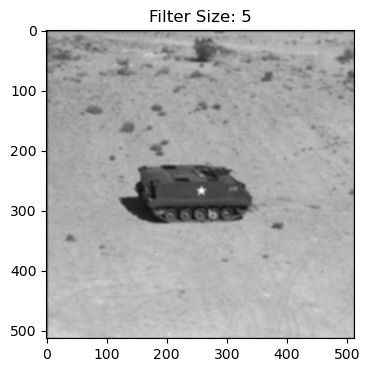

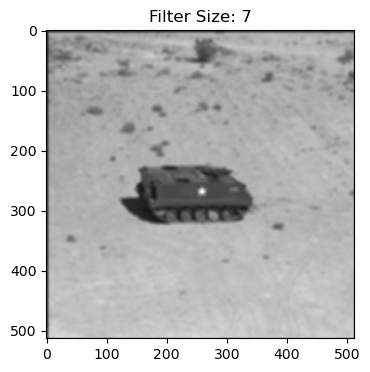

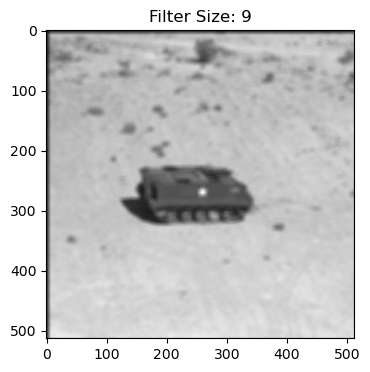

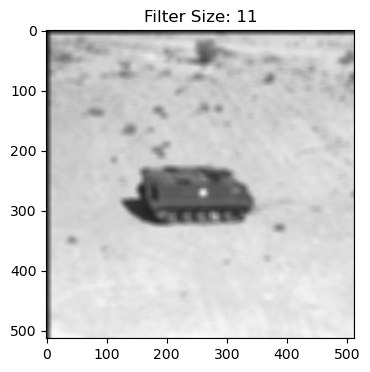

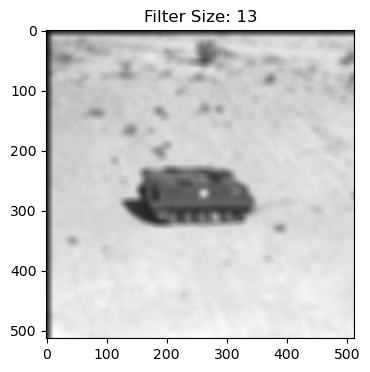

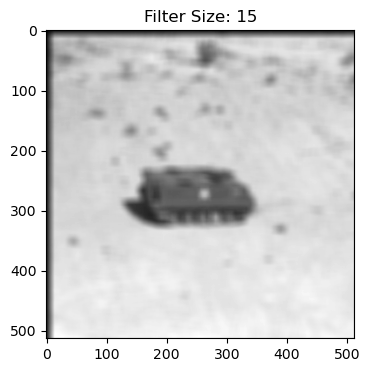

In [142]:
display_image(image1, title="Original Image")
display_image(noisy_image, title="Noisy Image")

for filter_size in range (3, 16, 2):
    averaging_filter = np.ones((filter_size, filter_size)) / (filter_size * filter_size)
    filtered_image = linearConv_withDFT(noisy_image, averaging_filter)
    display_image(filtered_image[0:noisy_image.shape[0] + 1, 0:noisy_image.shape[1] + 1], title = f"Filter Size: {filter_size}")

As the noising effect is reduced, the image is blurred more and more. An ideal filter size from my observations is 5.

(b) Gaussian filter of size 5 × 5. Experiment with the standard deviation $σ_h$ of the filter from 0.5 to 5 in steps of 0.5
and observe its effect on denoising. What happens when you keep the standard deviation of the filter constant
but vary the kernel size?

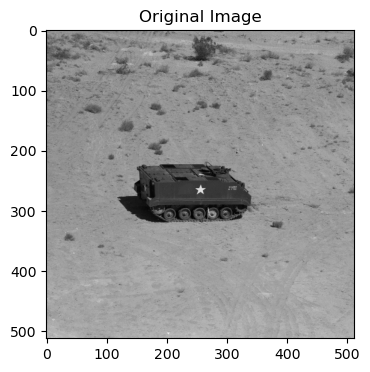

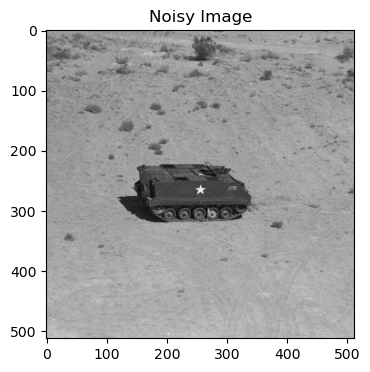

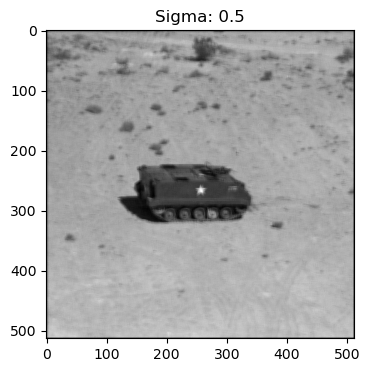

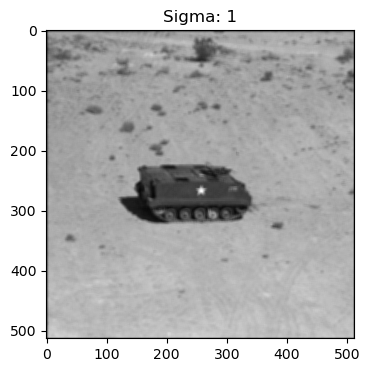

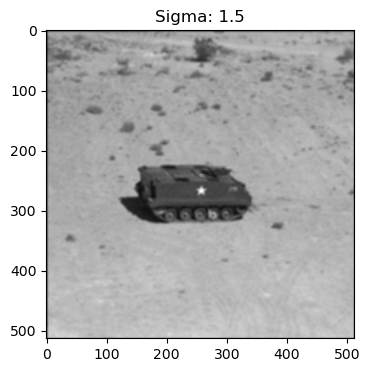

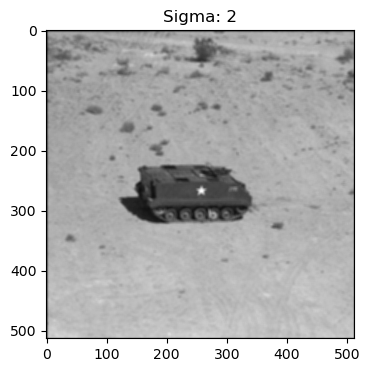

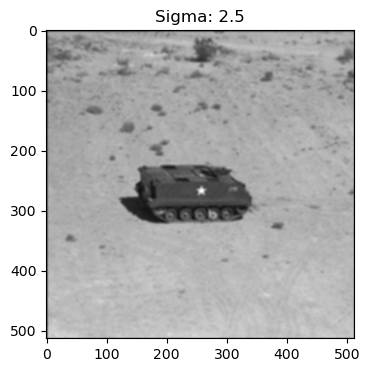

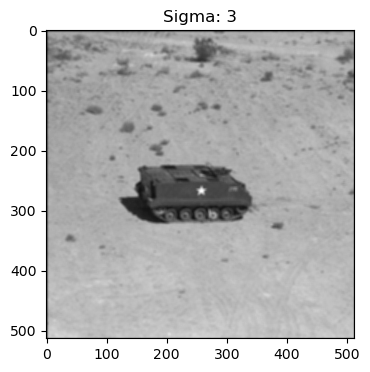

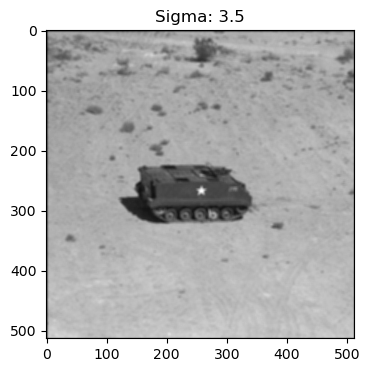

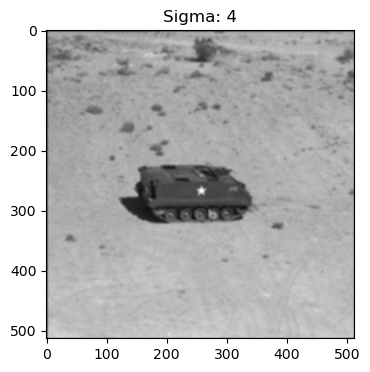

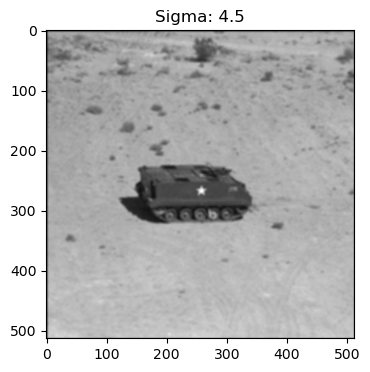

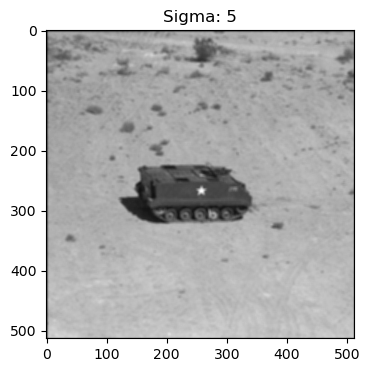

In [143]:
sigma_values = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

display_image(image1, title = "Original Image")
display_image(noisy_image, title = "Noisy Image")

for sigma in sigma_values:
    gaussian_filter = gaussianFilter(sigma, 5, 5)
    filtered_image = np.real(linearConv_withDFT(noisy_image, np.real(IDFT(gaussian_filter))))
    display_image(filtered_image[0:noisy_image.shape[0] + 1,0: noisy_image.shape[0] + 1], title = f"Sigma: {sigma}")

As the value of $\sigma$ increases, the blurring effect becomes more and results in more smoothing. Hence, it reduces the noise.

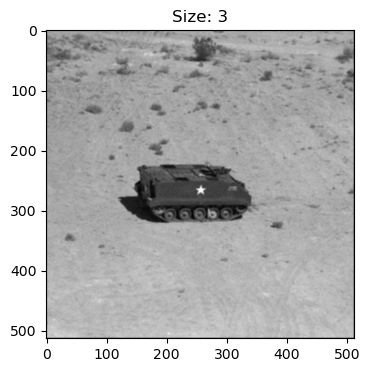

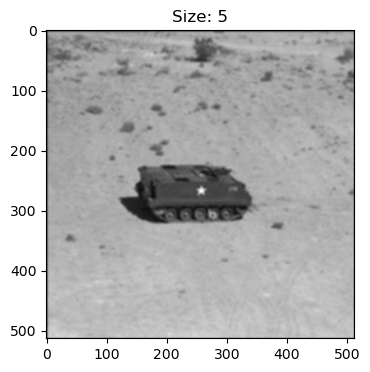

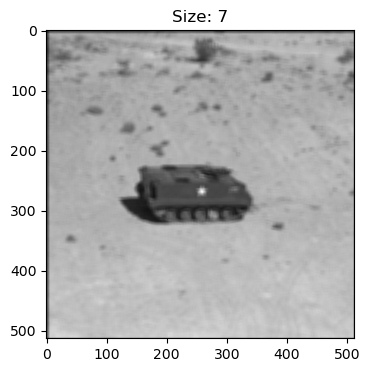

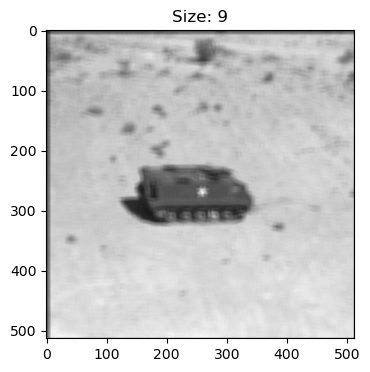

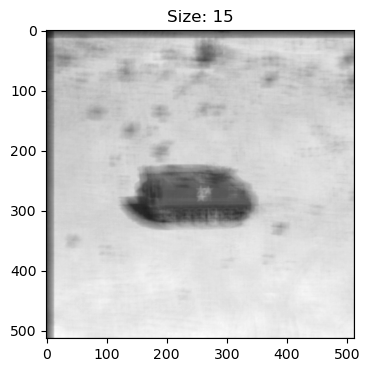

In [144]:
# keeping sigma constant at 1.5 and changing the filter size
filter_sizes = [3, 5, 7, 9, 15]

for filter_size in filter_sizes:
    gaussian_filter = gaussianFilter(1.5, filter_size, filter_size)
    filtered_image = linearConv_withDFT(noisy_image, np.real(IDFT(gaussian_filter)))
    
    display_image(filtered_image[0:noisy_image.shape[0] + 1,0: noisy_image.shape[0] + 1], title = f"Size: {filter_size}")

When the value of $\sigma$ is kept constant and the size of the kernel is increased, the the blurring effect becomes visibly more.

2. In this problem you will explore how edge detection and enhancement can be achieved using linear band pass and
high pass filters. Work with the mandrill image (from the USC dataset) in this question. Apply each of the band pass
and high pass filters you designed in Question 2 to this image and observe the output. Tabulate your observations for
each filter parameter choice.

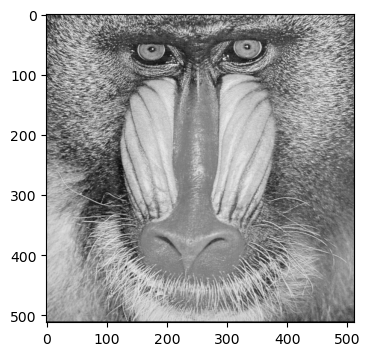

In [145]:
from PIL import Image

image2 = np.array(Image.open('misc/4.2.03.tiff').convert('L'))
display_image(image2)

With filter size: 8


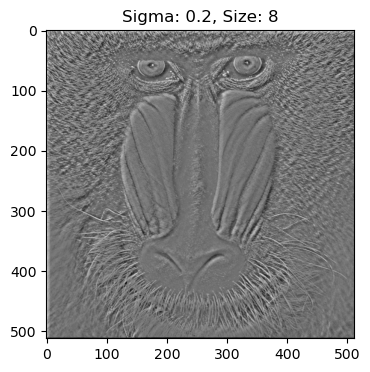

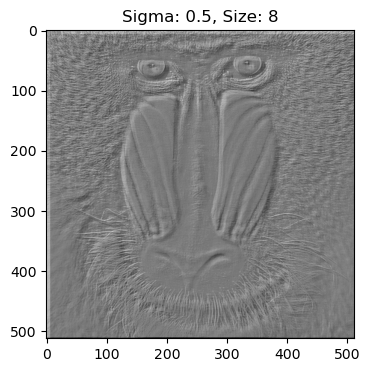

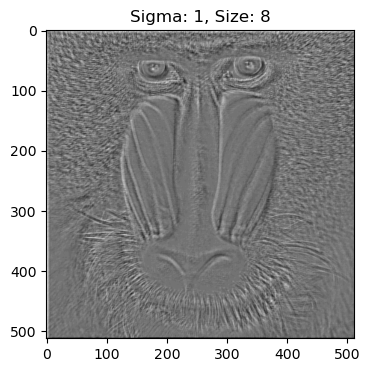

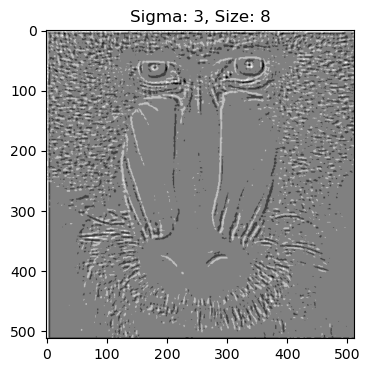

With filter size: 16


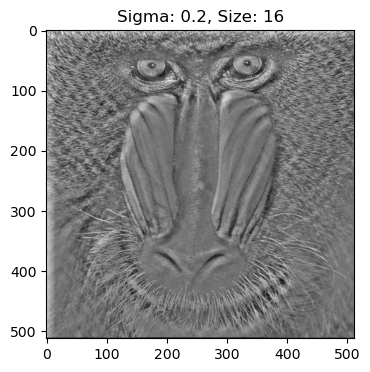

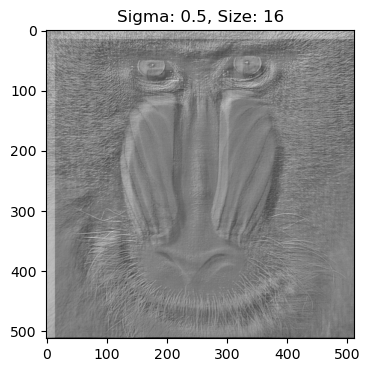

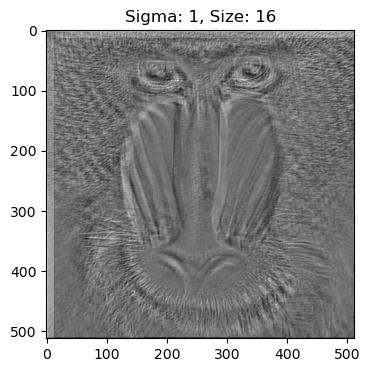

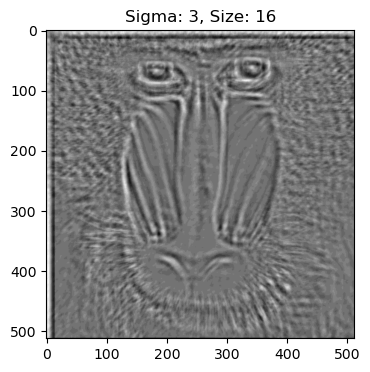

With filter size: 32


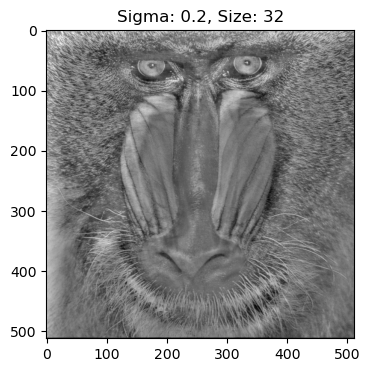

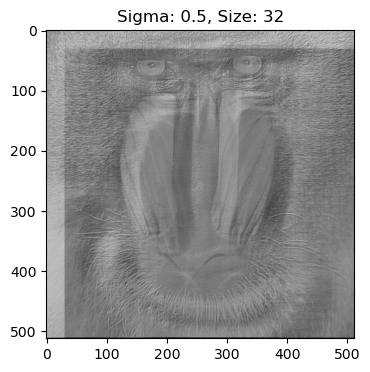

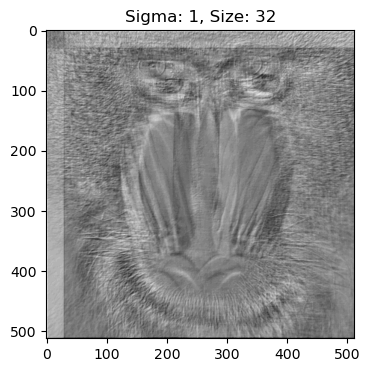

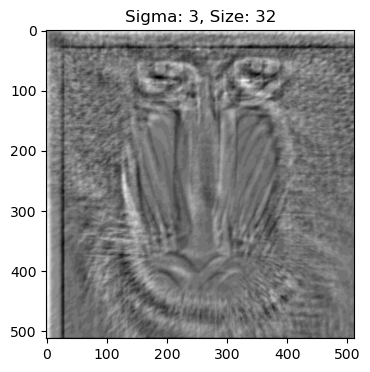

In [146]:
sigma_values = [0.2, 0.5, 1, 3]
filter_sizes = [8, 16, 32]

for filter_size in filter_sizes:
    print("With filter size:", filter_size)
    for sigma in sigma_values:
    
        bandPassFilter = DoG(sigma, 1.5 * sigma, filter_size, filter_size)
        filtered_image = np.real(linearConv_withDFT(image2, np.real(IDFT(bandPassFilter))))

        display_image(filtered_image[0:image2.shape[0], 0:image2.shape[1],], title = f"Sigma: {sigma}, Size: {filter_size}")

The image becomes sharper as we increase the $\sigma$. 
When we increase the size of the kernel, the image gets a bit distorted.

With Filter size: 8


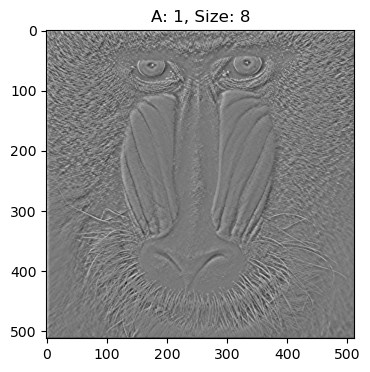

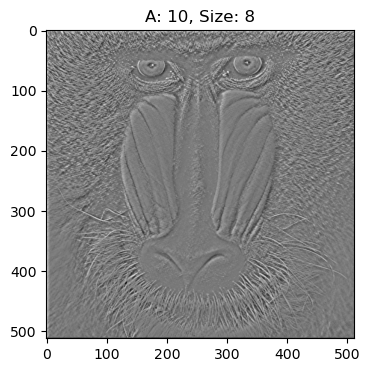

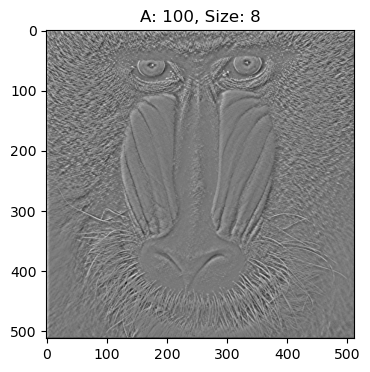

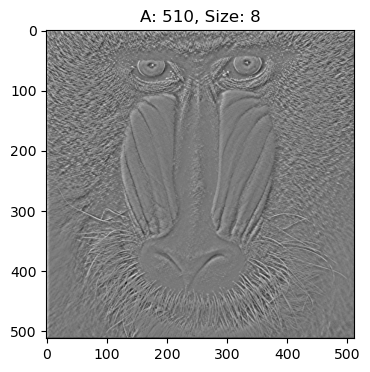

With Filter size: 16


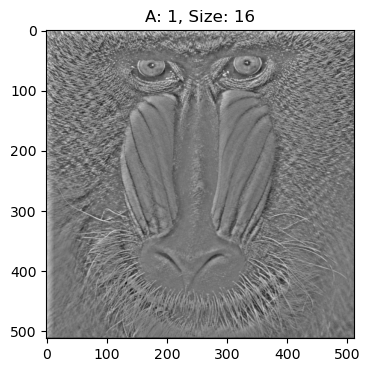

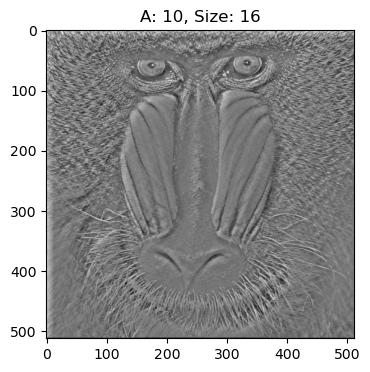

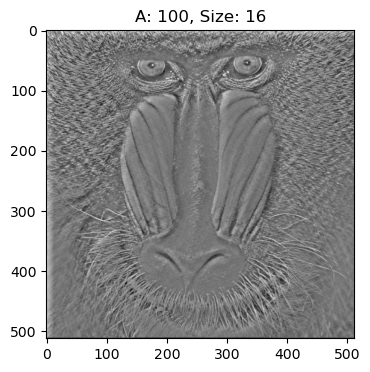

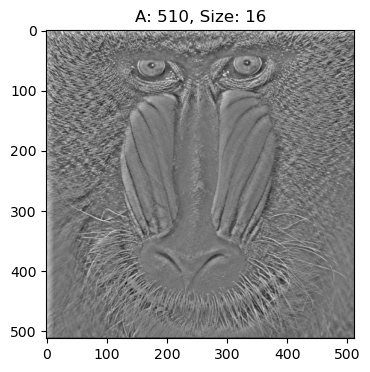

With Filter size: 32


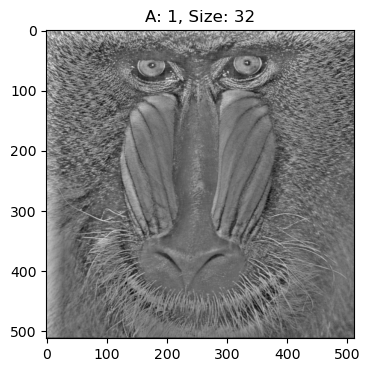

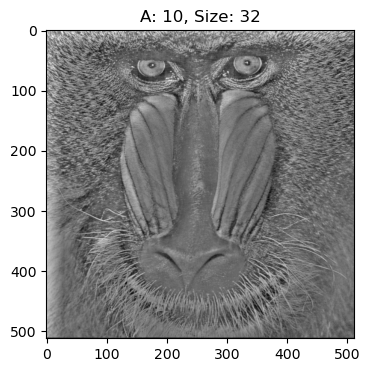

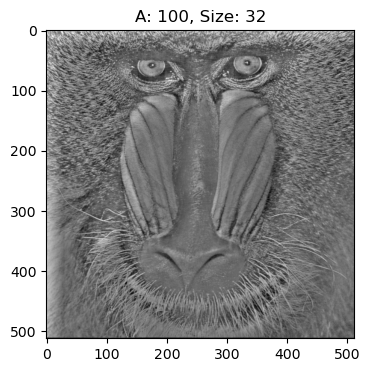

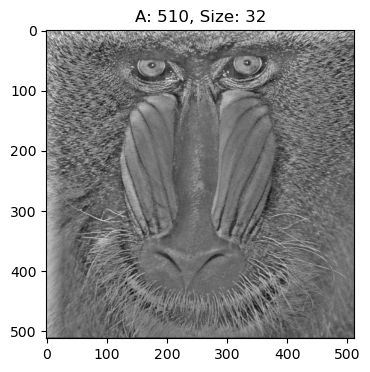

In [147]:
A = [1, 10, 100, 510]
filter_sizes = [8, 16, 32]

for filter_size in filter_sizes:
    print("With Filter size:", filter_size)
    for a in A:
    
        highPassFilter = laplacian(1, filter_size, filter_size)
        filtered_image = np.real(linearConv_withDFT(image2, np.real(IDFT(highPassFilter))))

        display_image(filtered_image[0:image2.shape[0], 0:image2.shape[1],], title = f"A: {a}, Size: {filter_size}")

As A changes, there is no visible observation. However, as the size increases, the image gets sharper.